In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
import pyspark.sql.functions as F
from pyspark.sql.types import StringType
import re
from pyspark.sql.functions import udf
from decouple import config

# Read dataset and explore

In [2]:
spark = (SparkSession
         .builder
         .master('local[*]')
         .config("spark.jars", "/home/jovyan/postgresql-42.7.4.jar")
         .getOrCreate())
spark.sparkContext.setLogLevel('OFF')

24/11/08 22:48:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


Spark UI Link: http://lab.vitucal.com:4040/jobs/

In [3]:
schema1 = """
user STRING,
timestamp TIMESTAMP,
hours DOUBLE,
project STRING
"""

In [4]:
df_init = spark.read.csv("dailycheckins.csv", header=True, schema=schema1)

In [5]:
df_init.printSchema()

root
 |-- user: string (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- hours: double (nullable = true)
 |-- project: string (nullable = true)



In [6]:
df_init.show(truncate=False)

+-------+------------------------+-----+--------------------+
|user   |timestamp               |hours|project             |
+-------+------------------------+-----+--------------------+
|ned    |2019-09-27 00:00:00     |8.0  |bizdev              |
|robert |NULL                    |8.0  |bizdev              |
|ned    |NULL                    |4.0  |bizdev              |
|ned    |2019-09-26 00:00:00     |1.0  |cultureandmanagement|
|ned    |2019-09-26 00:00:00     |1.5  |project-00          |
|ned    |2019-09-26 00:00:00     |1.0  |project-43          |
|jaime  |NULL                    |2.0  |project-00          |
|jaime  |2018-12-21 00:00:00     |0.5  |project-47          |
|jaime  |2018-12-21 00:00:00     |3.5  |project-47          |
|jaime  |2018-12-20 00:00:00     |1.5  |project-00          |
|jaime  |2018-12-20 00:00:00     |1.5  |project-30          |
|jaime  |2018-12-20 00:00:00     |1.0  |project-47          |
|jaime  |2018-12-20 00:00:00     |3.0  |project-47          |
|catelyn

In [7]:
df_init.show(3, vertical=True, truncate=False)

-RECORD 0------------------------
 user      | ned                 
 timestamp | 2019-09-27 00:00:00 
 hours     | 8.0                 
 project   | bizdev              
-RECORD 1------------------------
 user      | robert              
 timestamp | NULL                
 hours     | 8.0                 
 project   | bizdev              
-RECORD 2------------------------
 user      | ned                 
 timestamp | NULL                
 hours     | 4.0                 
 project   | bizdev              
only showing top 3 rows



In [8]:
df_init.count()

20500

In [9]:
df_init.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df_init.columns]).show()

+----+---------+-----+-------+
|user|timestamp|hours|project|
+----+---------+-----+-------+
|   5|     2047|    0|      0|
+----+---------+-----+-------+



5 users are NULL

In [10]:
df_init.filter("user IS NULL").show()

+----+--------------------+-----+----------+
|user|           timestamp|hours|   project|
+----+--------------------+-----+----------+
|NULL|2017-12-27 10:36:...|  4.0|project-40|
|NULL|2017-12-27 10:36:...|  3.0|  learning|
|NULL|2017-10-12 10:31:...| 2.75|project-47|
|NULL|2017-10-12 10:31:...|  4.0|    bizdev|
|NULL|2017-10-12 10:31:...|  1.0|   transit|
+----+--------------------+-----+----------+



# Initial Remarks on Exploration
In the code above I try to first see what is contained in the dataset:
- show some rows
- count of rows
- Try to apply strict schema to the columns

Apparent observations
- `user` column has 5 nulls, probably NULL names
- A lot of nulls in the `timestamp` columns, I'm assuming here that not all records in this column is on a consistent datetime format hence theres a lot of nulls

Moving on
- Let's just have timestamp as STRING to load them all, if no nulls great. We just have to convert different formats into timestamp and then convert them all in a single format (I'm thinking just as date YYYY-MM-DD)

In [11]:
schema2 = """
user STRING,
timestamp STRING,
hours DOUBLE,
project STRING
"""

In [12]:
df = spark.read.csv("dailycheckins.csv", header=True, schema=schema2)

In [13]:
df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+---------+-----+-------+
|user|timestamp|hours|project|
+----+---------+-----+-------+
|   5|        0|    0|      0|
+----+---------+-----+-------+



Looks like no nulls in the `timestamp` column. Let's inspect the format of the dates

In [14]:
df.show(truncate=False)

+-------+----------------------------+-----+--------------------+
|user   |timestamp                   |hours|project             |
+-------+----------------------------+-----+--------------------+
|ned    |2019-09-27 00:00:00 UTC     |8.0  |bizdev              |
|robert |09/27/2019 12:00 AM         |8.0  |bizdev              |
|ned    |26 сентября 2019 00:00      |4.0  |bizdev              |
|ned    |2019-09-26 00:00:00 UTC     |1.0  |cultureandmanagement|
|ned    |2019-09-26 00:00:00 UTC     |1.5  |project-00          |
|ned    |2019-09-26 00:00:00 UTC     |1.0  |project-43          |
|jaime  |12/21/2018 12:00 AM         |2.0  |project-00          |
|jaime  |2018-12-21 00:00:00 UTC     |0.5  |project-47          |
|jaime  |2018-12-21 00:00:00 UTC     |3.5  |project-47          |
|jaime  |2018-12-20 00:00:00 UTC     |1.5  |project-00          |
|jaime  |2018-12-20 00:00:00 UTC     |1.5  |project-30          |
|jaime  |2018-12-20 00:00:00 UTC     |1.0  |project-47          |
|jaime  |2

Looks like we're handling different date time formats, e.g.
- 2019-09-27 00:00:00 UTC
- 09/27/2019 12:00 AM
- 26 сентября 2019 00:00
- 2018-11-26 14:47:36.0429 UTC

To process this we might need to:
- convert russian date format to english
- appropriately convert to timestamp all the different datetime formats

# Handle Russian formatted dates

For handling russian formatted dates, I figured that they are just names of the month. So I'll just utilize a udf to replace russian month names to english month names if they occur in the string

In [15]:
@udf
def translate_month(russian_date):
    """unction to replace Russian months with English"""
    month_translation = {
        "января": "January", "февраля": "February", "марта": "March", "апреля": "April", 
        "мая": "May", "июня": "June", "июля": "July", "августа": "August", "сентября": "September", 
        "октября": "October", "ноября": "November", "декабря": "December"
    }
    
    # Regex pattern to detect Russian month names
    russian_month_pattern = re.compile(r'\b(января|февраля|марта|апреля|мая|июня|июля|августа|сентября|октября|ноября|декабря)\b')
    for ru_month, en_month in month_translation.items():
        russian_date = russian_date.replace(ru_month, en_month)
    return russian_date

In [16]:
df = df.withColumn(
    "parsed_timestamp", translate_month(F.col("timestamp"))
)

# Handle different date formats, and convert to date format only

After the russian date handling, I have identified 4 regex case to handle the conversion to their respective format's timestamp and then converted to date format to make all of them uniform

Some afterthoughts:
- These are the formats I have encountered in this dataset if more formats are expected in future datasets that does not match the current ones then another regex case can be added to handle them
- In this dataset russian dates were the difference, but if there ever was a case that other language formats exists (e.g. greek, other cyrillic, chinese, korean) they need to be translated by modifying the udf and adding other cases.
- Or just have the source data fix their timestamps into a uniform format instead of handling different formats

In [17]:
df = df.withColumn(
    "parsed_timestamp_2",
    F.when(F.col("parsed_timestamp").rlike(r"\d{1,} \S+ \d{4} \d{2}:\d{2}"), F.to_timestamp("parsed_timestamp", "d MMMM yyyy HH:mm"))
    .when(F.col("parsed_timestamp").rlike(r"\d{2}/\d{2}/\d{4} \d{2}:\d{2} (AM|PM)"), F.to_timestamp("parsed_timestamp", "MM/dd/yyyy hh:mm a"))
    .when(F.col("parsed_timestamp").rlike(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2} UTC"), F.to_timestamp("parsed_timestamp", "yyyy-MM-dd HH:mm:ss 'UTC'"))
    .when(F.col("parsed_timestamp").rlike(r"\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}\.\d{1,} UTC"), F.to_timestamp("parsed_timestamp", "yyyy-MM-dd HH:mm:ss.SSSSSS 'UTC'"))
    .otherwise(None)
)

In [18]:
df = df.withColumn("date", F.to_date(F.date_format("parsed_timestamp_2", "yyyy-MM-dd")))

# View results

In [19]:
display(df.count())
df.select("user", "date", "hours", "project").show(truncate=False)

20500

+-------+----------+-----+--------------------+
|user   |date      |hours|project             |
+-------+----------+-----+--------------------+
|ned    |2019-09-27|8.0  |bizdev              |
|robert |2019-09-27|8.0  |bizdev              |
|ned    |2019-09-26|4.0  |bizdev              |
|ned    |2019-09-26|1.0  |cultureandmanagement|
|ned    |2019-09-26|1.5  |project-00          |
|ned    |2019-09-26|1.0  |project-43          |
|jaime  |2018-12-21|2.0  |project-00          |
|jaime  |2018-12-21|0.5  |project-47          |
|jaime  |2018-12-21|3.5  |project-47          |
|jaime  |2018-12-20|1.5  |project-00          |
|jaime  |2018-12-20|1.5  |project-30          |
|jaime  |2018-12-20|1.0  |project-47          |
|jaime  |2018-12-20|3.0  |project-47          |
|catelyn|2018-11-26|0.6  |opsandadmin         |
|catelyn|2018-11-26|0.45 |opsandadmin         |
|catelyn|2018-11-26|0.4  |cultureandmanagement|
|catelyn|2018-11-26|0.08 |security            |
|catelyn|2018-11-26|0.68 |project-43    

Erm we might have some duplicate columns here? Might be legit that some tasks can be repeated in a certain day? Need more context. But I'm gonna assume these are duplicates and will be dropping them

In [20]:
duplicate_rows = df.select("user", "date", "hours", "project") \
    .groupBy("user", "date", "hours", "project") \
    .count() \
    .filter("count > 1") \
    .orderBy("count", ascending=False)
duplicate_rows.show()
duplicate_rows.count()

+------+----------+-----+--------------------+-----+
|  user|      date|hours|             project|count|
+------+----------+-----+--------------------+-----+
|robert|2017-12-06|  0.5|              bizdev|    5|
|robert|2018-06-25|  1.0|              bizdev|    5|
|robert|2018-11-19|  1.0|         opsandadmin|    5|
|   ned|2018-01-23|  1.0|              bizdev|    4|
|  arya|2018-09-19|  1.0|          project-32|    4|
|   ned|2017-11-02|  0.5|         opsandadmin|    4|
|ramsay|2017-09-07|  0.5|          project-16|    4|
|   ned|2018-03-14|  1.0|cultureandmanagement|    4|
|robert|2017-11-28|  1.0|              bizdev|    4|
| bronn|2018-10-29|  1.0|             website|    4|
| varys|2018-07-04|  1.0|cultureandmanagement|    4|
|robert|2018-03-07|  1.0|              bizdev|    4|
|robert|2018-10-23|  4.0|              bizdev|    4|
|   jon|2018-09-24|  0.5|          project-25|    4|
|   ned|2018-01-08|  1.0|cultureandmanagement|    4|
|   jon|2018-11-09|  0.5|          project-25|

861

In [21]:
duplicate_rows.agg(F.sum("count").alias("total_count")).collect()[0]["total_count"]

1850

In [22]:
df = df.select("user", "date", "hours", "project").dropDuplicates()
df.count()

19511

In [23]:
19511 + 1850 - 861

20500

# Check data validity, see nulls in all columns

In [24]:
df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns]).show()

+----+----+-----+-------+
|user|date|hours|project|
+----+----+-----+-------+
|   5|   0|    0|      0|
+----+----+-----+-------+



# Prepare problematic and non-problematic df that is ready for saving

In the code below I have separated the df into two:
- Good data `df_save` ready to be saved into `checkins`
    - Ideally this is clean enough and ready to be saved in the main table
    - If this type of data is ingested periodically I would prefer to have a `process_date` column
    - New data will be compared with the old data old data would be windowed like this
    - `(ROW_NUMBER() OVER (PARTITION BY user, project ORDER BY date) AS rn WHERE rn = 1)`
    - Then subtract the old data with the new data, result must be new data to be appended.
- Bad data `df_problems` ready to be saved into and `checkin_problems` table
    - for tracking of invalid rows that shouldn't be saved and can be a source of logs when people ask where the missing rows are when $\text{source dataset count} \neq \text{destination dataset count}$
    - Added `process_date` column to take into account problem rows for a specific process run date
    - If this ETL can run multiple times can also extend to include `run_id` on top of `process_date`
- Save Duplicate data for a run into another table? It might be a good idea to save the duplicate info for a certain run. To find the root cause why there's duplicate data incoming.
 
Finally save to postgres DB, mode=append, I'll be assuming this will be a job that runs on a certain cron interval that always appends to existing data. Ideally we won't have to update previous records. If we have to we need a versioning approach, what I'll recommend is SCD Type 2 approach discussed [here](https://www.sqlshack.com/implementing-slowly-changing-dimensions-scds-in-data-warehouses/) where a new row is added with a new column to track which identifies oldest from newest (probably another date/timestamp column)

In [25]:
df_problem = df.filter(
    # Check if any column is null
    " OR ".join([f"{c} IS NULL" for c in df.columns])
).select("user", "date", "hours", "project").withColumn(
    "process_date",
    F.to_date(F.date_format(F.expr("cast(current_date() as timestamp)"), "yyyy-MM-dd"))
)

In [26]:
display(df_problem.count())
df_problem.show()
df_problem.printSchema()

5

+----+----------+-----+----------+------------+
|user|      date|hours|   project|process_date|
+----+----------+-----+----------+------------+
|NULL|2017-10-12|  1.0|   transit|  2024-11-08|
|NULL|2017-12-27|  3.0|  learning|  2024-11-08|
|NULL|2017-10-12| 2.75|project-47|  2024-11-08|
|NULL|2017-10-12|  4.0|    bizdev|  2024-11-08|
|NULL|2017-12-27|  4.0|project-40|  2024-11-08|
+----+----------+-----+----------+------------+

root
 |-- user: string (nullable = true)
 |-- date: date (nullable = true)
 |-- hours: double (nullable = true)
 |-- project: string (nullable = true)
 |-- process_date: date (nullable = true)



In [27]:
df_save = df.select("user", "date", "hours", "project").filter(
    # Check if any column is null
    " AND ".join([f"{c} IS NOT NULL" for c in df.columns])
)

In [28]:
display(df_save.count())
df_save.show()
df_save.printSchema()

19506

+----------+----------+-----+--------------------+
|      user|      date|hours|             project|
+----------+----------+-----+--------------------+
|      robb|2018-11-21|  1.5|            learning|
|     hound|2018-11-20|  2.5|         opsandadmin|
|   stannis|2018-11-12| 0.45|         opsandadmin|
|     jorah|2018-11-08|  0.5|                  pm|
|   catelyn|2018-11-07| 0.98|         opsandadmin|
|   catelyn|2018-11-07| 1.25|            security|
|    cersei|2018-11-07|  2.0|            learning|
|      jeor|2018-11-06|  2.0|            learning|
|      jeor|2018-11-05|  2.5|            learning|
|melisandre|2018-11-05| 0.42|            learning|
|     hound|2018-11-05|  1.5|         opsandadmin|
|      jeor|2018-11-01|  2.0|        datastrategy|
|     sansa|2018-10-29|  0.5|             website|
|   joffrey|2018-10-22|  0.5|          project-25|
|      jeor|2018-10-20| 0.75|cultureandmanagement|
|     bronn|2018-10-16| 1.25|         opsandadmin|
|       ned|2018-10-11|  1.5|  

In [29]:
jdbc_url = f"jdbc:postgresql://{config('DB_HOST')}:{config('DB_PORT')}/postgres"
properties = {
    "user": config("DB_USER"),
    "password": config("DB_PASS"),
    "driver": "org.postgresql.Driver"
}

In [30]:
df_save.write.jdbc(url=jdbc_url, table="checkins", mode="append", properties=properties)

In [31]:
df_problem.write.jdbc(url=jdbc_url, table="checkin_problems", mode="append", properties=properties)

# Serving the web app
Checkout the api docs http://lab.vitucal.com/docs \
To serve the webapp I'd like to use [FastApi](https://fastapi.tiangolo.com/), as the community deems it very fast and can generate its own API docs. I'll just have these paths:

- `/` - Basic hello root reply
    - 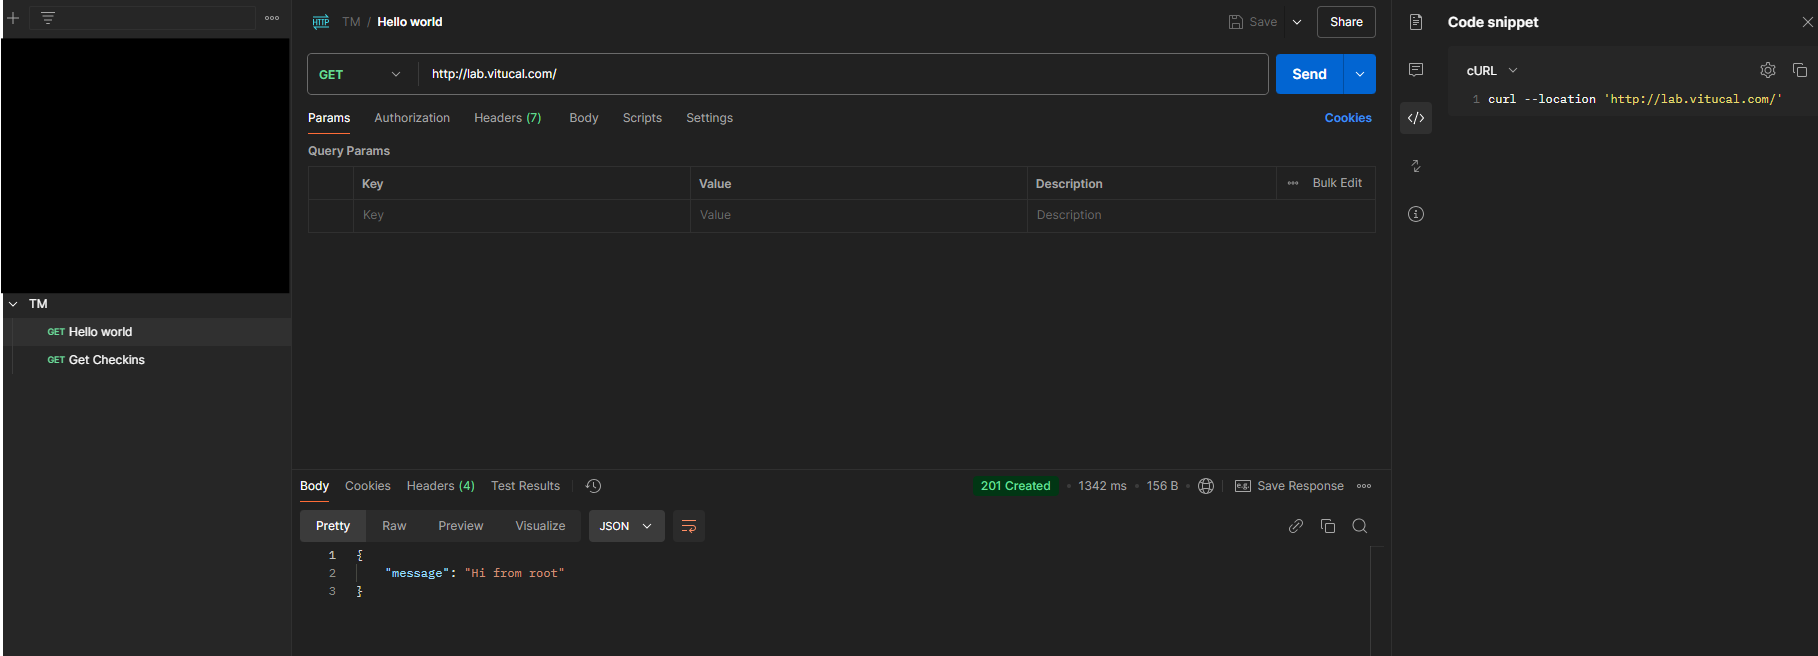 
- `/checkins`
    - `user`, `page`, and `page_size` as query params
    - will give a paginated result so that if result count will be high we can still manage the load by pagination
    - total_count in the return means the total number of records match
    - returned_count is the number of record returned per page
    - 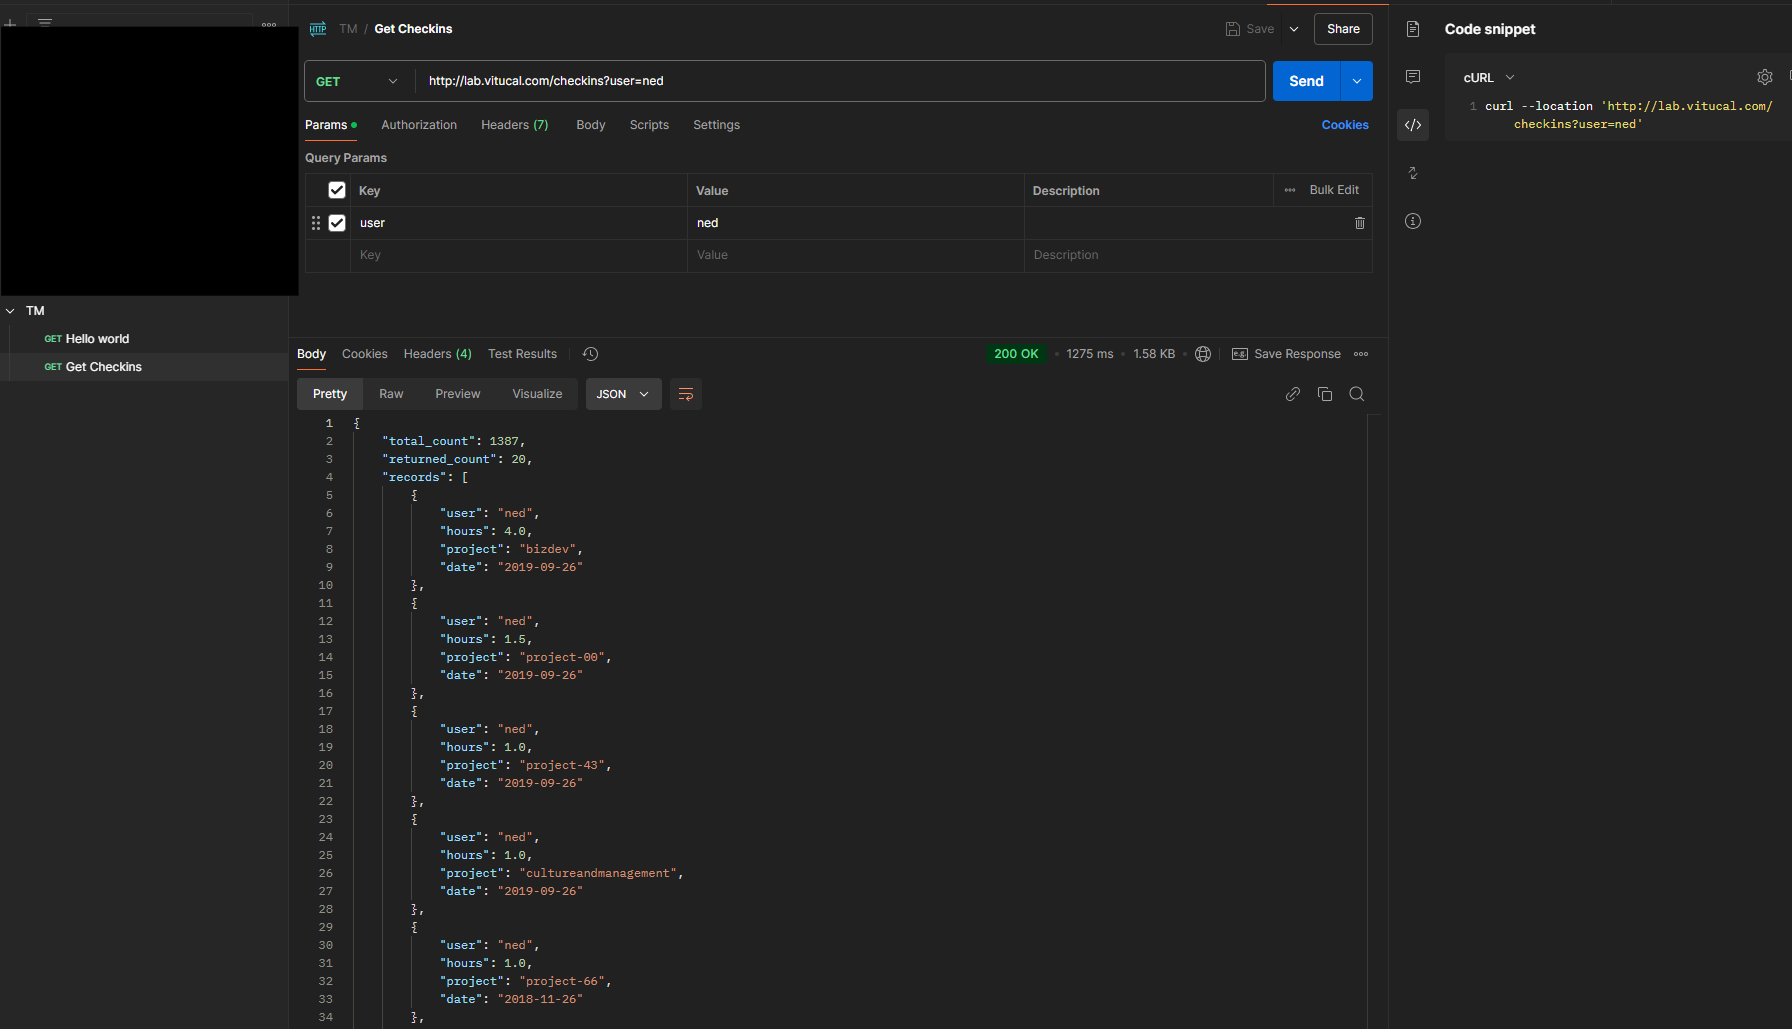
    - 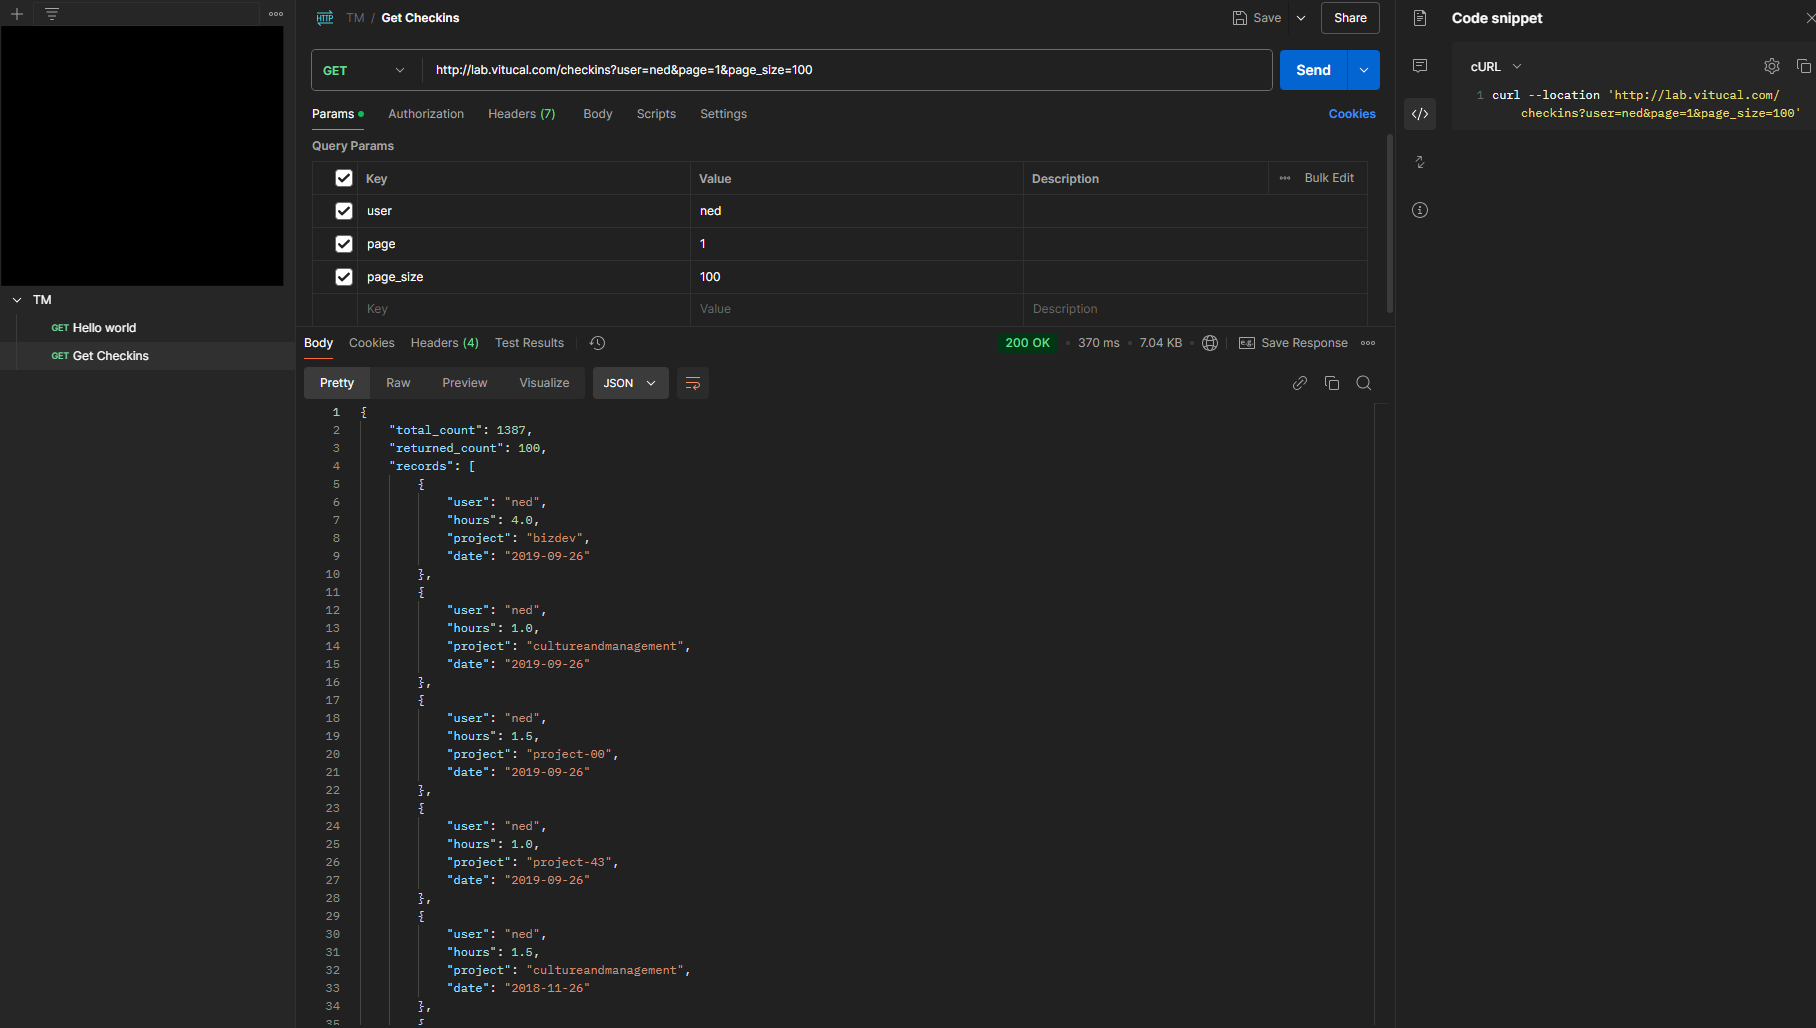

# Appendix

## Setting up postgres in ubuntu
```bash
sudo apt update
sudo apt install postgresql postgresql-contrib
sudo systemctl start postgresql
sudo systemctl enable postgresql
sudo -i -u postgres
psql

# important in using psycopg2-binary in EC2
sudo apt-get install libpq-dev

# 
ALTER USER postgres WITH PASSWORD 'newpassword';
SHOW port;
```

## `.env` variables for `python-decouple`
```
DB_HOST=xxx
DB_PORT=xxx
DB_NAME=xxx
DB_USER=xxx
DB_PASS=xxx
```

## Serving jupyterlab with .env variables
```bash
conda activate pyspark
export $(cat ~/.env | xargs)
jupyter lab --no-browser --ip="*" --port=8888
```

## Serving FastApi with uvicorn
```bash
export $(cat ~/.env | xargs)
sudo /home/ubuntu/.conda/envs/pyspark/bin/uvicorn app.main:app --host 0.0.0.0 --port 80
```

## Python requirements
```
fastapi
psycopg2-binary
pyspark
python-decouple
pandas
numpy
```

## Running tests
Need:
```
pytest
pytest-cov
```

.coveragerc:
```
# Remove logger from test
[coverage:run]
omit =
    app/logger/__init__.py
```

Ran it in my Windows Machine
```powershell
# in Part 2 as root dir
$env:PYTHONPATH = "."
# Make sure .env present in your root
pytest -vv tests/ --cov=app --cov-report=html
```

Coverage Result:\
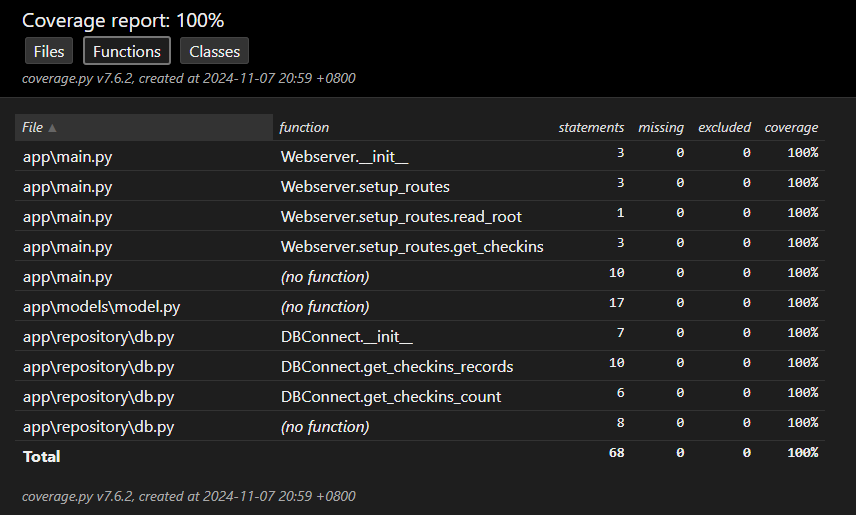